In [4]:
from src import compile_fit_rnn, sampling_rnn, plot_history_rnn
import tensorflow.keras as KERAS
from timeseries_generator import LinearTrend, Generator, WhiteNoise, WeekdayFactor
import pandas as pd
import numpy as np

# RNN PART

### Create data

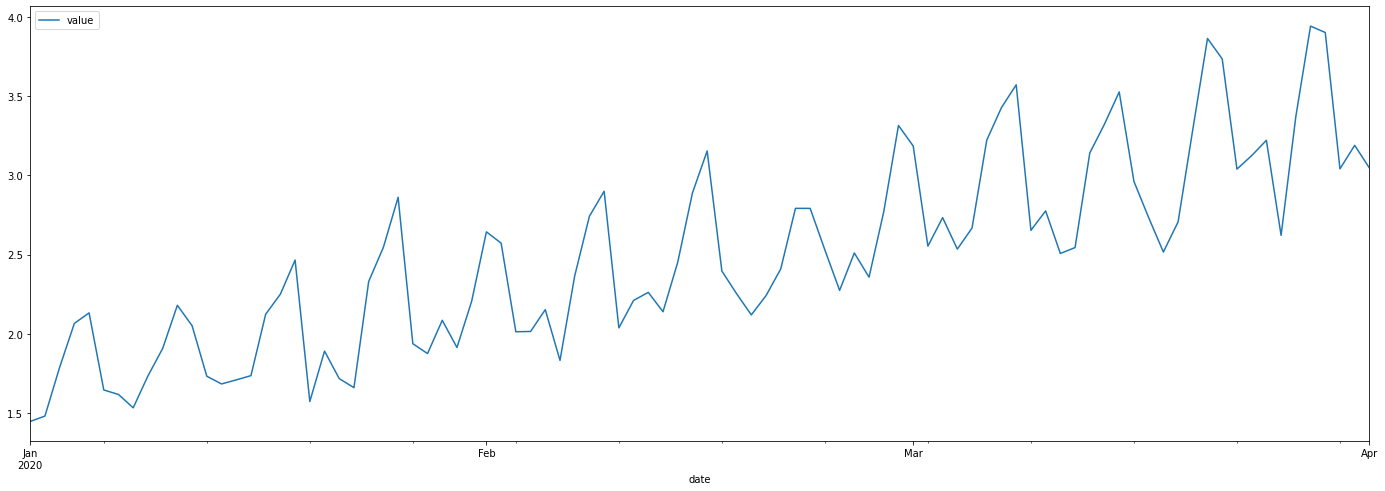

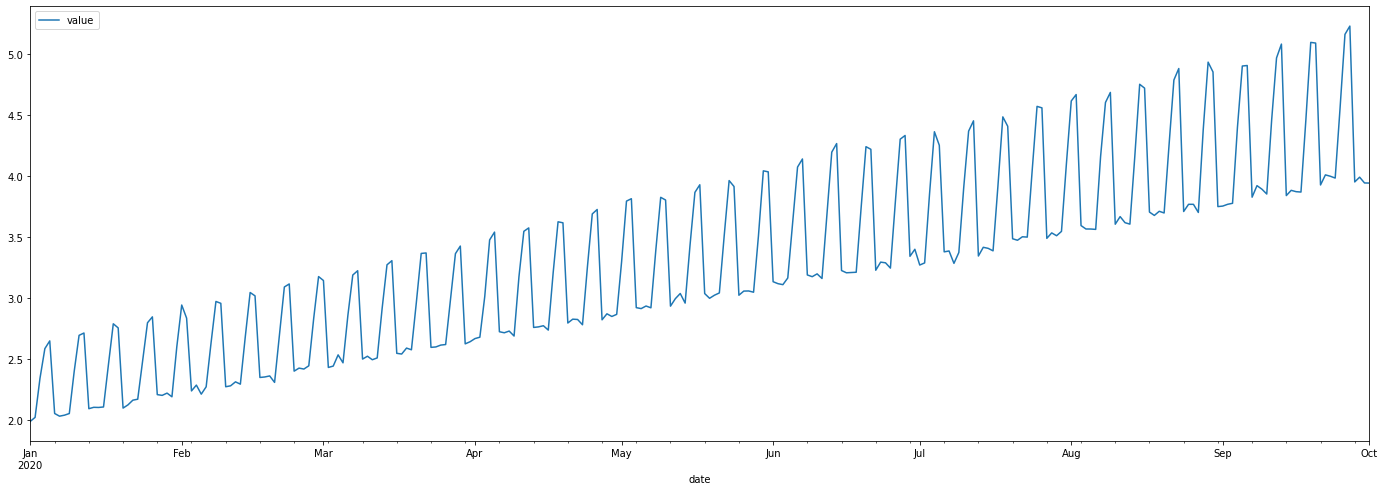

In [5]:
# base data
# setting up a linear tren
lt = LinearTrend(coef=1.5, offset=0.5, col_name="my_linear_trend")
w = WeekdayFactor()
g = Generator(factors={lt, w}, features=None, date_range=pd.date_range(start="01-01-2020", end="04-01-2020"))

# update by adding some white noise to the generator
wn = WhiteNoise(stdev_factor=0.05)
g.update_factor(wn)
data = np.asarray( g.generate().value )
g.plot()


# three times
# setting up a linear tren
lt = LinearTrend(coef=2.0, offset=1., col_name="my_linear_trend")
g = Generator(factors={lt,w}, features=None, date_range=pd.date_range(start="01-01-2020", end="10-01-2020"))

# update by adding some white noise to the generator
wn = WhiteNoise(stdev_factor=0.01)
g.update_factor(wn)
data_3t = np.asarray( g.generate().value )
g.plot()

### Process data

In [6]:
# normalized
from sklearn.preprocessing import MinMaxScaler
data_norm = MinMaxScaler().fit_transform(data.reshape((-1, 1)))
data_3t_norm = MinMaxScaler().fit_transform(data_3t.reshape((-1, 1)))

# sampling
x, y = sampling_rnn(data_norm, 5)
x_3t, y_3t = sampling_rnn(data_3t_norm, 5)
print(x.shape, y.shape)
print(x_3t.shape, y_3t.shape)

# train test split, back 33%
x_train, x_test, y_train, y_test = x[:len(x)//3 * 2], x[len(x)//3 * 2:], y[:len(y)//3 * 2], y[len(y)//3 * 2:]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_3t_train, x_3t_test, y_3t_train, y_3t_test = x_3t[:len(x_3t)//3*2], x_3t[len(x_3t)//3*2:], y_3t[:len(y_3t)//3*2], y_3t[len(y_3t)//3*2:]
print(x_3t_train.shape, x_3t_test.shape, y_3t_train.shape, y_3t_test.shape)

(87, 1, 5) (87, 1)
(270, 1, 5) (270, 1)
(58, 1, 5) (29, 1, 5) (58, 1) (29, 1)
(180, 1, 5) (90, 1, 5) (180, 1) (90, 1)


### Base data model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


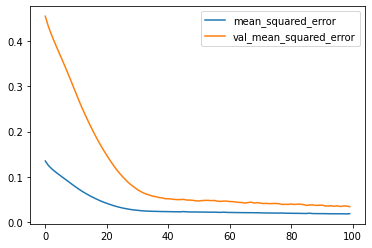

mean_squared_error
0.01889103464782238
val_mean_squared_error
0.03439765051007271


In [7]:
# LSTM
model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.LSTM(32, activation='relu'),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_train, y_train), (x_test, y_test))

plot_history_rnn(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3744      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________


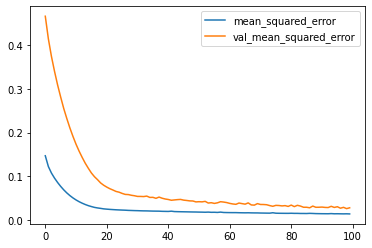

mean_squared_error
0.014385669492185116
val_mean_squared_error
0.028365779668092728


In [8]:
# GRU

model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.GRU(32, activation='relu'),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_train, y_train), (x_test, y_test))

plot_history_rnn(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                2432      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


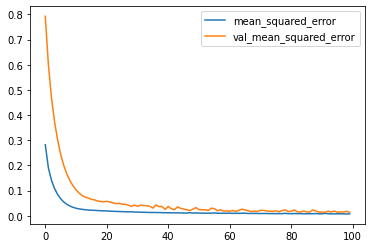

mean_squared_error
0.00764522235840559
val_mean_squared_error
0.014316570945084095


In [9]:
# BiRNN

model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.Bidirectional(
            KERAS.layers.SimpleRNN(32, activation='relu')
        ),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_train, y_train), (x_test, y_test))

plot_history_rnn(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 32)             1216      
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 32)             2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

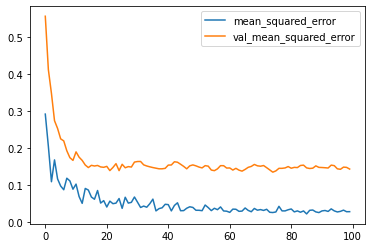

mean_squared_error
0.02821636013686657
val_mean_squared_error
0.14358767867088318


In [10]:
# Deep RNN

model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.SimpleRNN(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'),
        KERAS.layers.Dropout(0.5),
        KERAS.layers.SimpleRNN(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'),
        KERAS.layers.Dropout(0.5),
        KERAS.layers.SimpleRNN(32),
        KERAS.layers.Dropout(0.5),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_train, y_train), (x_test, y_test))

plot_history_rnn(history)

### three times data model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


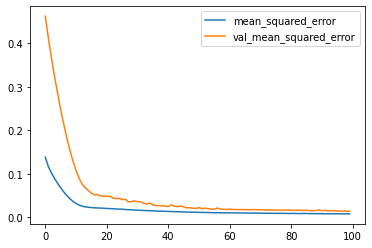

mean_squared_error
0.007520953193306923
val_mean_squared_error
0.01358753815293312


In [11]:
model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.LSTM(32, activation='relu'),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_3t_train, y_3t_train), (x_3t_test, y_3t_test))

plot_history_rnn(history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3744      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________


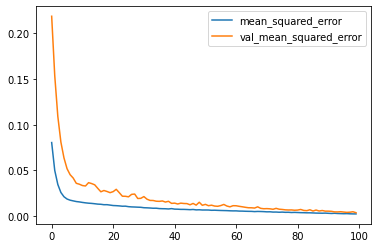

mean_squared_error
0.0023305772338062525
val_mean_squared_error
0.003665240714326501


In [12]:
# GRU

model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.GRU(32, activation='relu'),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_3t_train, y_3t_train), (x_3t_test, y_3t_test))

plot_history_rnn(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                2432      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


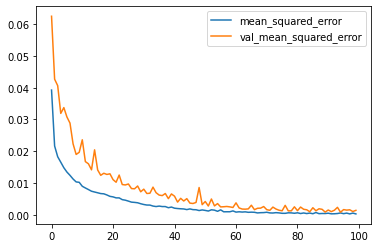

mean_squared_error
0.0002453446504659951
val_mean_squared_error
0.0013715929817408323


In [13]:
# BiRNN

model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.Bidirectional(
            KERAS.layers.SimpleRNN(32, activation='relu')
        ),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_3t_train, y_3t_train), (x_3t_test, y_3t_test))

plot_history_rnn(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 1, 32)             1216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 1, 32)             2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

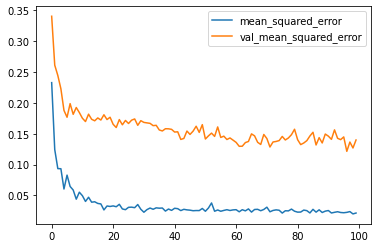

mean_squared_error
0.02155446819961071
val_mean_squared_error
0.13989289104938507


In [14]:
# Deep RNN

model = KERAS.models.Sequential(
    [
        KERAS.layers.InputLayer(input_shape=(1, 5)), 
        KERAS.layers.SimpleRNN(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'),
        KERAS.layers.Dropout(0.5),
        KERAS.layers.SimpleRNN(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'),
        KERAS.layers.Dropout(0.5),
        KERAS.layers.SimpleRNN(32),
        KERAS.layers.Dropout(0.5),
        KERAS.layers.Dense(1)
    ]
)

history = compile_fit_rnn(model, (x_3t_train, y_3t_train), (x_3t_test, y_3t_test))

plot_history_rnn(history)